In [1]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import torch
from IPython.display import display
from scipy.stats import entropy
from datasets import load_dataset, Dataset, load_metric
import os.path
import requests
from bs4 import BeautifulSoup

d:\Program Files (x86)\Miniconda3\envs\Masterarbeit\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_steps=20,
    evaluation_strategy="epoch"
    )
metric = load_metric("accuracy")

In [3]:
def compute_metrics_accuracy(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        print("Predictions", predictions, "Labels", labels)
        return metric.compute(predictions=predictions, references=labels)
        
tokenizer = AutoTokenizer.from_pretrained("oliverguhr/german-sentiment-bert")
trainer = Trainer(model= AutoModelForSequenceClassification.from_pretrained("oliverguhr/german-sentiment-bert"),
                args=training_args,
                train_dataset=None,
                eval_dataset=None,
                tokenizer=tokenizer,
                data_collator=None,
                compute_metrics = compute_metrics_accuracy)

In [ ]:

# trainer = Trainer(model= AutoModelForSequenceClassification.from_pretrained("oliverguhr/german-sentiment-bert"),
#                 args=training_args,
#                 train_dataset=None,
#                 eval_dataset=tokenized_dataset_test,
#                 tokenizer=tokenizer,
#                 data_collator=data_collator,
#                 compute_metrics = compute_metrics_accuracy)

In [4]:
pd.set_option('display.max_rows', None)
def calculate_entropy(logits):
    probas = torch.nn.Softmax(dim=1)(torch.from_numpy(logits))
    samples_entropy = entropy(probas.transpose(0, 1).cpu())
    samples_entropy = torch.from_numpy(samples_entropy)
    return samples_entropy

def preprocess_function(examples):
    return tokenizer(examples["texts"], padding = True, truncation=True)

def get_new_sample_active_learning(number_of_comments):

    ### We read in the csv that stores all of our already annotated data
    df = pd.read_csv("annotated_data/annotated_data_with_users.csv", names=["ID", "Date", "Time", "Comment Level", "Username", "Opinion", "Sentiment",
                     "topic_comment", "Topic_article", "Comment", "Method"])

    already_present_data = 0
    with open("annotated_data/annotated_data_training.txt", encoding="utf-8", mode="r+") as y:
        for line in y.readlines():
            if line != "\n":
                already_present_data += 1

    ### Check if we already have active learned comments that we annotated
    if os.path.isfile('annotated_data/active_learning_comments.csv'):
        progress_csv =pd.read_csv("annotated_data/active_learning_comments.csv",names=["ID", "Date", "Time", "Comment Level", "Username", "Opinion", "Sentiment", "topic_comment", "Topic_article", "Comment", "Method"], encoding="utf-8-sig", header=None)


    ### Stores comments as string that we already have in active learning csv
    bereits_comments = []
    for comment in progress_csv.Comment:
        bereits_comments.append(comment)

    ### Int which shows how many comments (manual random sampled + active learn sampled) we already have annotated
    progress = already_present_data + len(bereits_comments)


    ### Load in all scraped comments from web in csv, sliced on [progress: progress + number_of_comments]
    alle_kommentare = pd.read_csv("shuffled_corona_relevante_kommentare.txt", names=["ID", "Date", "Time", "Comment Level", "Username", "Opinion", "Sentiment", "topic_comment", "Topic_article", "Comment"], 
                                    delimiter="\t", index_col=False, skiprows=progress, nrows=number_of_comments )
    


    ### Drop all rows that are already present in the active learned csv to we don't annotate twice
    alle_kommentare = alle_kommentare.loc[~alle_kommentare["Opinion"].isin(bereits_comments)]
    alle_kommentare.reset_index(inplace=True, drop=True)
    ### Tokenize texts and get entropy, take topk 
    texte = {"texts" : [x for x in alle_kommentare["Opinion"]]}
    texte_ds= Dataset.from_dict(texte)
    tokenized_text = texte_ds.map(preprocess_function, batched=True)
    entropies = calculate_entropy(trainer.predict(tokenized_text).predictions)
    indexes = torch.topk(entropies, int(100)).indices
    
    # if os.path.isfile('annotated_data/active_learning_comments.csv'):
    #     progress_csv =pd.read_csv("annotated_data/active_learning_comments.csv",names=["ID", "Date", "Time", "Comment Level", "Username", "Opinion", "Sentiment", "topic_comment", "Topic_article", "Comment"], encoding="utf-8-sig", header=None)
    #     print(type(progress_csv))
    #     display(progress_csv)
    #     for row, index in progress_csv.iterrows():
    #         print(row, index)
    newdf = pd.DataFrame(columns=["ID", "Date", "Time", "Comment Level", "Username", "Opinion", "Sentiment", "Topic_comment", "Topic_article", "Comment", "Method"])
    for nummer, x in enumerate(indexes):
        satz = texte["texts"][x]
        
        opinion = input(f"Opinion --- {satz}")
        print(type(opinion), opinion, opinion not in ["neutral", "positive", "negative", "exit"])
        while opinion not in ["neutral", "positive", "negative", "exit"]:
            
            opinion = input(f"Opinion --- {satz}")    
        sentiment = input(f"Sentiment --- {satz}")
        
        while sentiment not in ["neutral", "positive", "negative"]:
            sentiment = input(f"Sentiment --- {satz}")

        
        request = requests.get("https://www.spiegel.de/wissenschaft/medizin/corona-news-am-samstag-die-wichtigsten-entwicklungen-zu-sars-cov-2-und-covid-19-a-" +alle_kommentare.loc[int(x), "ID"])
        soup = BeautifulSoup(request.content, "html.parser")
        title = soup.find("title").text
        subtitle = soup.find("meta", property="og:description")["content"]

        topic_article = input("Topic Article ------" +title + "\n" + subtitle + " " + alle_kommentare.loc[int(x), "ID"])  
        topic_comment = input("Topic comment" + satz)


        row = [alle_kommentare.loc[alle_kommentare.Opinion == satz]]
        newdf = newdf.append(row)
        newdf.reset_index(inplace=True, drop=True)
        newdf.iloc[nummer,alle_kommentare.columns.get_loc("Topic_article")] = topic_article
        newdf.iloc[nummer,alle_kommentare.columns.get_loc("topic_comment")] = topic_comment
        newdf.iloc[nummer,alle_kommentare.columns.get_loc("Sentiment")] = sentiment
        newdf.iloc[nummer,alle_kommentare.columns.get_loc("Comment")] = satz
        newdf.iloc[nummer,alle_kommentare.columns.get_loc("Opinion")] = opinion

        print(opinion, sentiment,topic_article, topic_comment)
        

    newdf = newdf.drop(columns=list(newdf.columns[-2:]))
    display(newdf)
    newdf.to_csv("annotated_data/active_learning_comments.csv", mode="a", encoding="utf-8-sig", index=False, header=False)
            # df.append(line.split("\t")[0] + "\t" + line.split("\t")[1] + "\t" + line.split("\t")[2] + "\t" + line.split("\t")[3] + "\t" + line.split("\t")[4] + "\t" + opinion + "\t"
            #                       + sentiment + "\t" + klasse1 + "\t" +  klasse2 + "\t" + kommentar + "\n")
        



In [5]:
### Takes n/10 comments with highest entropy from n pool of comments
# 10500
get_new_sample_active_learning(23500)

100%|██████████| 22/22 [00:05<00:00,  4.25ba/s]
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: texts.
***** Running Prediction *****
  Num examples = 21567
  Batch size = 8
100%|██████████| 2696/2696 [16:21<00:00,  3.40it/s]

<class 'str'> positive False
positive positive wirtschaft wirtschaft
<class 'str'> neutral False
neutral neutral impfung infektion
<class 'str'> negative False
negative negative demos demos
<class 'str'> negative False
negative neutral überblick maßnahmen
<class 'str'> neutral False
neutral neutral XXX XXX
<class 'str'> negative False
negative negative überblick XXX
<class 'str'> negative False
negative neutral maßnahmen lockdown
<class 'str'> positive False
positive positive überblick infektion
<class 'str'> negative False
negative negative wirtschaft wirtschaft
<class 'str'> neutral False
neutral neutral china maßnahmen
<class 'str'> neutral False
neutral neutral virus virus
<class 'str'> negative False
negative negative überblick infektion
<class 'str'> negative False
negative neutral maßnahmen maßnahmen
<class 'str'> negative False
negative negative lockdown lockdown
<class 'str'> neutral False
neutral neutral virus virus
<class 'str'> positive False
positive neutral lockdown lockd

,ID,Date,Time,Comment Level,Username,Opinion,Sentiment,Topic_comment,Topic_article,Comment
0,0210360b-673b-46a4-bb95-4998e452f1a4,2020-04-01,08:09,0,Pragmatiker307,positive,positive,wirtschaft,wirtschaft,Ein absolut sinnvoller Vorschlag! Wir rechnen ...
1,fce7e73a-a4f7-4d1f-bc7b-29bcdf75e4ea,2020-11-04,19:04,0,Johannes-V3LbKl6Wg,neutral,neutral,infektion,impfung,Die Natur findet einen Weg. So wie in der Tier...
2,365c7c4f-c0d2-4f19-9c2a-ec24d13c354b,2020-11-22,13:15,0,Adnauseam,negative,negative,demos,demos,"Bevor man ""querdenkt"" sollte man erst einmal n..."
3,e5218e94-f986-41a8-87a6-545f8aeffdfd,2020-11-25,07:49,0,Kommentatorin-O8jcTKMZg,negative,neutral,maßnahmen,überblick,Mal etwas Statistik zu den Todeszahlen: 65% de...
4,3f5986b8-d9d6-492f-a562-81d3bccbe4fa,2020-06-14,14:19,0,Roman-mNNrQZzMg,neutral,neutral,XXX,XXX,"Sehr geehrte Frau Köppe, ich spreche Ihnen für..."
5,73f15804-cd98-40a6-bfbf-48c3adf57ba4,2021-03-05,09:54,0,Lobhudel,negative,negative,XXX,überblick,Jetzt ist Eigeninitiative gefragt: Habe gerade...
6,271b0379-2821-49fb-ace6-d09379aa4022,2020-10-29,15:02,0,Kellerkind,negative,neutral,lockdown,maßnahmen,"Wenn irgendwo privat gefeiert wird, klopft man..."
7,4736f7ec-6396-4f5f-991b-1f83e5f5df66,2021-03-07,17:19,0,Hospitalitaet,positive,positive,infektion,überblick,+++ Britische Forscher infizieren Freiwillige ...
8,3cf088de-fff6-4ad9-873f-1983fce892f2,2020-07-21,06:08,0,June,negative,negative,wirtschaft,wirtschaft,"Die Schuldenaufnahme wird jetzt ""historisch"" g..."
9,879cf899-8615-4ce6-9d43-e2d52927a8d7,2020-04-18,07:44,0,He-sFf8uX9Zg,neutral,neutral,maßnahmen,china,"Ist ja klar, dass politisches Kapital aus dem ..."


In [4]:
active_learning_df = pd.read_csv("annotated_data/active_learning_comments.csv", names=["ID", "Date", "Time", "Comment Level", "Username", "Opinion", "Sentiment", "Topic_comment", "Topic_article", "Comment", "Method"])
active_learning_df["Method"] = "manual_al"
active_learning_df.to_csv("annotated_data/active_learning_comments.csv",encoding="utf-8-sig", index=False, header=False)

In [5]:
active_learning_df = pd.read_csv("annotated_data/active_learning_comments.csv", names=["ID", "Date", "Time", "Comment Level", "Username", "Opinion", "Sentiment", "Topic_comment", "Topic_article", "Comment", "Method"])
current_kommentare_df = pd.read_csv("annotated_data/annotated_data_with_users_für_al.csv", names=["ID", "Date", "Time", "Comment Level", "Username", "Opinion", "Sentiment", "Topic_comment", "Topic_article", "Comment", "Method"])
full_df = current_kommentare_df.append(active_learning_df)
full_df  = full_df.sample(frac=1).reset_index(drop=True)
full_df.to_csv("annotated_data/annotated_data_with_users_and_al.csv", encoding="utf-8-sig", index=False, header=False)

<AxesSubplot:>

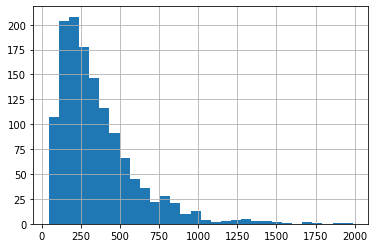

In [30]:
lengths = [len(i) for i in full_df["Comment"]]
pd.Series(lengths).hist(bins = 30)

In [6]:
import pandas as pd
df_with_XXX =pd.read_csv("annotated_data/annotated_data_with_users_and_al.csv",names=["ID", "Date", "Time", "Comment Level", "Username", "Opinion", "Sentiment", "topic_comment", "Topic_article", "Comment", "Method"], encoding="utf-8-sig", header=None)
df_test = df_with_XXX.loc[df_with_XXX["topic_comment"] != "XXX"]
df_test.to_csv("annotated_data/annotated_data_with_users_and_al_cleaned.csv", encoding="utf-8-sig", index=False, header=False)